In [1]:
from __future__ import division, print_function, absolute_import

import tmm
import math
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

from enum import Enum
from typing import NamedTuple

In [2]:
class Parameters(NamedTuple):
    f_k: int
    n_k: int
    f_m: int
    n_m: int
    k_m: int
    f_a: int
    n_a: int

In [3]:
def cauchy(A, B, wavelength):
    return A + B*wavelength**-2

def melanin_imaginary(wavelength):
    a_m = 0.56
    b_m = 270
    return a_m * math.exp(-wavelength / b_m)

def keratin_index(wavelength):
    A_k = 1.532
    B_k = 5890
    return cauchy(A_k, B_k, wavelength)

def melanin_index(wavelength):
    A_m = 1.648
    B_m = 23700
    return cauchy(A_m, B_m, wavelength)

In [4]:
def calc_keratin_layer(wavelength):
    f_k = 1
    n_k = keratin_index(wavelength)
    f_m = 0
    n_m = 0
    k_m = 0
    f_a = 0
    n_a = 0
    return Parameters(f_k, n_k, f_m, n_m, k_m, f_a, n_a)

In [5]:
def calc_melanin_layer(wavelength):
    f_k = 0
    n_k = 0
    f_m = 1
    n_m = melanin_index(wavelength)
    k_m = melanin_imaginary(wavelength)
    f_a = 0
    n_a = 0
    return Parameters(f_k, n_k, f_m, n_m, k_m, f_a, n_a)

In [6]:
def calc_melanosome_internal_layer_index(wavelength):
    f_k = 0.05
    n_k = keratin_index(wavelength)
    f_m = 0.4
    n_m = melanin_index(wavelength)
    k_m = melanin_imaginary(wavelength)
    f_a = 0.55
    n_a = 1
    return Parameters(f_k, n_k, f_m, n_m, k_m, f_a, n_a)

In [7]:
def calc_refractive_index(params: Parameters):
    n_eff = (params.f_k*params.n_k
            + params.f_m*(params.n_m + complex(0, params.k_m))
            + params.f_a*params.n_a)

    return n_eff

In [8]:
def calc_layers(wavelength):
    # Thicknesses in nm
    keratin_cortex_thickness = 5
    keratin_separation_thickness = 50
    melanosome_membrane_thickness = 30
    # Note: this can be changed to adjust periodicity
    melanosome_internal_thickness = 100
    top_melanosome_internal_thickness = 50

    keratin_layer_index = calc_refractive_index(calc_keratin_layer(wavelength))
    melanosome_membrane_index = calc_refractive_index(calc_melanin_layer(wavelength))
    melanosome_internal_index = calc_refractive_index(calc_melanosome_internal_layer_index(wavelength))

    # Init layers to first infinite air layer
    layers = [[np.inf, 1]]

    # Add keratin cortex layer
    layers.append([keratin_cortex_thickness, keratin_layer_index])

    # Add top melanosome layer
    layers.append([melanosome_membrane_thickness, melanosome_membrane_index])
    layers.append([top_melanosome_internal_thickness, melanosome_internal_index])
    layers.append([melanosome_membrane_thickness, melanosome_membrane_index])

    # Add the rest of the keratin separation and melanosome layers
    melanosome_layers = 12
    melanosome_layers -= 1 # Because of the top melanosome layer
    for _ in range(melanosome_layers):
        layers.append([keratin_separation_thickness, keratin_layer_index])
        layers.append([melanosome_membrane_thickness, melanosome_membrane_index])
        layers.append([melanosome_internal_thickness, melanosome_internal_index])
        layers.append([melanosome_membrane_thickness, melanosome_membrane_index])

    # Add keratin cortex layer
    layers.append([keratin_cortex_thickness, keratin_layer_index])

    # Add last infinite air layer
    layers.append([np.inf, 1])

    return layers

In [9]:
class Material(Enum):
    KERATIN = 1
    MELANIN_MEMBRANE = 2
    MELANIN_INTERNAL = 3
    AIR = 4

In [10]:
def calc_slices(wavelength):
    # Thicknesses in nm
    keratin_cortex_thickness = 5
    keratin_separation_thickness = 50
    melanosome_membrane_thickness = 30
    # Note: this can be changed to adjust periodicity
    melanosome_internal_thickness = 100
    melanosome_internal_thickness_top = 50

    # Keratin cortex
    layers = [[Material.KERATIN, keratin_cortex_thickness]]

    # Top melanosome
    layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
    layers.append([Material.MELANIN_INTERNAL, melanosome_internal_thickness_top])
    layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    # Add the rest of the keratin separation and melanosome layers
    melanosome_layers = 12
    melanosome_layers -= 1 # Because of the top melanosome layer

    for _ in range(melanosome_layers):
        # Keratin separation
        layers.append([Material.KERATIN, keratin_separation_thickness])
        # Melanosome
        layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
        layers.append([Material.MELANIN_INTERNAL, melanosome_internal_thickness])
        layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    layers.append([Material.KERATIN, keratin_cortex_thickness])

    layers = np.array(layers)

    total_thickness = np.sum(layers[:, 1])

    slices = np.zeros(total_thickness)

    index = 0
    for layer in layers:
        material = layer[0]
        thickness = layer[1]
        slices[index:index+thickness] = material.value
        index += thickness

    slice_thickness = 10

    final_layers = [[np.inf, 1]]

    for i in range(0, total_thickness, slice_thickness):
        unique, counts = np.unique(slices[i:i+slice_thickness], return_counts=True)
        counts_dict = dict(zip(unique, counts))
        f_k = counts_dict.get(Material.KERATIN.value, 0) / slice_thickness
        f_m = counts_dict.get(Material.MELANIN_MEMBRANE.value, 0) / slice_thickness
        f_a = counts_dict.get(Material.AIR.value, 0) / slice_thickness

        f_k += counts_dict.get(Material.MELANIN_INTERNAL.value, 0) * 0.05 / slice_thickness
        f_m += counts_dict.get(Material.MELANIN_INTERNAL.value, 0) * 0.4 / slice_thickness
        f_a += counts_dict.get(Material.MELANIN_INTERNAL.value, 0) * 0.55 / slice_thickness

        params = Parameters(f_k, keratin_index(wavelength), f_m, melanin_index(wavelength),
                            melanin_imaginary(wavelength), f_a, 1)

        layer_index = calc_refractive_index(params)
        final_layers.append([10, layer_index])

    final_layers.append([np.inf, 1])

    return final_layers

Text(0.5, 1.0, 'Reflectance at normal incidence')

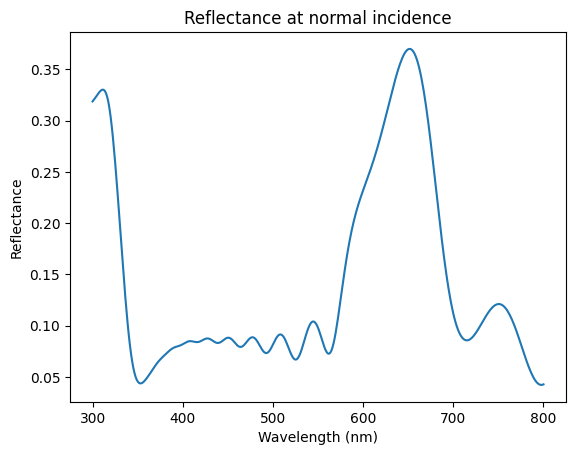

In [11]:
lambda_list = np.linspace(300,800,400) # in nm
T_list = []
for wavelength in lambda_list:
    layers = np.array(calc_layers(wavelength))
    T_list.append(tmm.coh_tmm('s', layers[:, 1], layers[:, 0].real, math.radians(0), wavelength)['R'])
plt.figure()
plt.plot(lambda_list,T_list)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Reflectance at normal incidence')

Text(0, 0.5, 'Refractive index @ 500 nm')

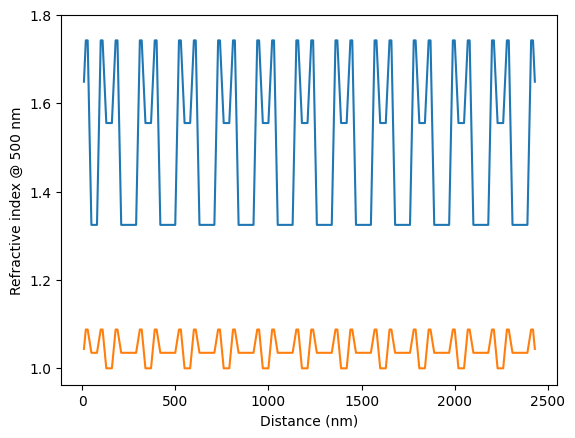

In [14]:
wavelength = 500 # in nm
layers = np.array(calc_slices(500))
cumsum = np.cumsum(layers[1:-1, 0])
plt.figure()
plt.plot(cumsum,layers[1:-1, 1].real)
plt.plot(cumsum,layers[1:-1, 1].imag + 1)
plt.yticks(np.arange(1.0, 1.81, 0.2))
plt.xlabel('Distance (nm)')
plt.ylabel('Refractive index @ 500 nm')